cSMC

In [1]:
import jax.numpy as jnp
from jax import random
from jax import grad, vmap, jit
from matplotlib import pyplot as plt
import seaborn as sns
from jax.config import config; config.update("jax_enable_x64", True)
%matplotlib inline

In [36]:
from melange.tests.utils import get_nondefault_potential_initializer, checker_function
from melange.smc import vSIS_lower_bound, SIS, generate_trajs, SIS_logW
import tqdm
from jax.lax import cond
import numpy as np
from melange.csmc import *

#define some parameters
N,T,Dx = 10000, 10, 1
potential, (mu, cov), dG = get_nondefault_potential_initializer(Dx)
cov = cov[0]
dt=1e-2

#define some _vanilla_ A, b fns
A_fn = lambda x, params: params
b_fn = lambda x, params: jnp.zeros(Dx)

#create the csmc container object
smc_obj= StaticULAControlledSMC(N, 
                            potential=potential,
                            forward_potential=potential, 
                            backward_potential=potential, 
                            A_fn = A_fn, #A_fn=lambda x, p: jnp.zeros((Dx, Dx)), 
                            b_fn = b_fn, #b_fn = lambda x, p: jnp.zeros(Dx),
                            A_params_len=1,
                            b_params_len=1,
                            Dx=1,
                            T=T
                           ) #create a controlled smc class

#create SMC parameters/functions
prop, logw, (init_Xs, init_logws) = smc_obj.get_fns() #pull the necessary functions from it
potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis] #define the potential parameters

prop_params = {
               'potential_params': potential_params,
               'forward_potential_params': potential_params,
               'backward_potential_params': potential_params[1:],
               'dt': dt
               } #potential parameters dictionary goes here
init_params = {'mus': jnp.array([mu]), 
               'covs': jnp.array([cov]),
               'mixture_weights': jnp.array([1.])} #define the initial params
model_params=None #there are no model parameters
y=jnp.arange(T) #the y data aren't important. just know that there are the same number of them as there are data
rs = random.PRNGKey(6) #define a random number 

#create the trajectories
Xs = generate_trajs(prop_params, model_params, y, rs, init_params, init_Xs, prop)
logWs = SIS_logW(Xs, prop_params, model_params, y, init_params, logw, init_logws, aggregate_works=False)
aggregated_logWs = jnp.cumsum(logWs, axis=0)
logZ = logsumexp(aggregated_logWs[-1,:]) - jnp.log(N)
print(f"the estimated logZ is {logZ}; the True logZ is {dG}")

print(f"now doing statistical sample; nom nom")
from melange.smc import vSIS_lower_bound
jvSIS = jit(vSIS_lower_bound, static_argnums=(5,6,7))
logZs = []

for i in tqdm.trange(100):
    rs, run_rs = random.split(rs)
    out_logZ = jvSIS(prop_params, model_params, y,  run_rs, init_params, prop, logw, (init_Xs, init_logws))
    logZs.append(out_logZ)


  0%|          | 0/100 [00:00<?, ?it/s]

the estimated logZ is -0.3494904538572321; the True logZ is -0.3465
now doing statistical sample; nom nom


DEBUG:absl:Compiling vSIS_lower_bound for args (ShapedArray(float64[9,1]), ShapedArray(float64[], weak_type=True), ShapedArray(float64[10,1]), ShapedArray(float64[10,1]), ShapedArray(int64[10]), ShapedArray(uint32[2]), ShapedArray(float64[1,1]), ShapedArray(float64[1]), ShapedArray(float64[1,1])).
100%|██████████| 100/100 [00:02<00:00, 33.94it/s]


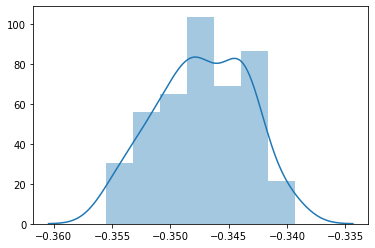

In [37]:
sns.distplot(logZs)

let's see if we can't get the twisting functions...

In [38]:
ADP_dict = smc_obj.get_ADP_fn()
print(ADP_dict.keys())
ADP_fn = ADP_dict['ADP']

dict_keys(['sum_square_diffs', 'loss', 'scipy_loss', 't0_scipy_loss', 'get_callback_fn', 'np_scipy_loss', 'np_t0_scipy_loss', 'np_scipy_loss_grad', 'np_t0_scipy_loss_grad', 'ADP'])


In [39]:
out_dict = ADP_fn(Xs, logWs, prop_params, verbose=True)

100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


In [40]:
out_dict

{'out_A_params': DeviceArray([[0.2411808 ],
              [0.21533811],
              [0.18930966],
              [0.16301932],
              [0.13656297],
              [0.10978213],
              [0.08282571],
              [0.0554628 ],
              [0.02790665]], dtype=float64),
 'out_b_params': DeviceArray([[0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.]], dtype=float64),
 'out_A0': DeviceArray([0.23910038], dtype=float64),
 'out_b0': DeviceArray([1.96265843e-05], dtype=float64),
 'loss_trace': [array([0.0954322 , 0.07760967, 0.03809855]),
  array([0.6508939]),
  array([0.64992903]),
  array([0.62721856]),
  array([0.62440323]),
  array([0.59485347]),
  array([0.55998865]),
  array([0.5919984]),
  array([0.55580362]),
  array([0.5492683])]}

alright, can we update the twisting iteration?

In [41]:
smc_obj.update_cSMC(out_dict['out_A_params'], out_dict['out_b_params'], out_dict['out_A0'], out_dict['out_b0'])

well that worked. now we have to see if we can run smc again (twisted) and try to observe an improvement

In [42]:
smc_obj.twisting_iteration

2

In [43]:
prop, logw, (init_Xs, init_logws) = smc_obj.get_fns() #pull the necessary functions from it
twist1_logZs = []

for i in tqdm.trange(100):
    rs, run_rs = random.split(rs)
    out_logZ = jvSIS(prop_params, model_params, y,  run_rs, init_params, prop, logw, (init_Xs, init_logws))
    twist1_logZs.append(out_logZ)

100%|██████████| 100/100 [00:03<00:00, 32.27it/s]


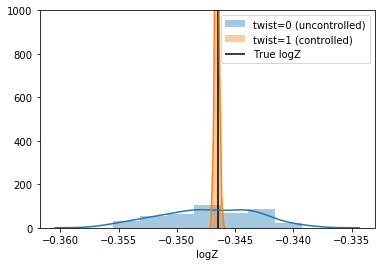

In [44]:
sns.distplot(logZs, label='twist=0 (uncontrolled)')
sns.distplot(twist1_logZs, label='twist=1 (controlled)')
plt.xlabel(f"logZ")
plt.vlines(dG,0,1000, label=f"True logZ")
plt.ylim(0,1000)
plt.legend()

now, we have to generate ensemble trajectories and works so that we can twist _again_

In [45]:
twist_1_Xs = generate_trajs(prop_params, model_params, y, rs, init_params, init_Xs, prop)
twist_1_logWs = SIS_logW(twist_1_Xs, prop_params, model_params, y, init_params, logw, init_logws, aggregate_works=False)

In [46]:
ADP_dict = smc_obj.get_ADP_fn()
print(ADP_dict.keys())
ADP_fn = ADP_dict['ADP']

dict_keys(['sum_square_diffs', 'loss', 'scipy_loss', 't0_scipy_loss', 'get_callback_fn', 'np_scipy_loss', 'np_t0_scipy_loss', 'np_scipy_loss_grad', 'np_t0_scipy_loss_grad', 'ADP'])


In [47]:
out_dict = ADP_fn(twist_1_Xs, twist_1_logWs, prop_params, verbose=True)

100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


In [48]:
out_dict

{'out_A_params': DeviceArray([[1.14078437],
              [0.92719429],
              [0.73231083],
              [0.55587318],
              [0.40075045],
              [0.26908349],
              [0.16247449],
              [0.08182895],
              [0.02742049]], dtype=float64),
 'out_b_params': DeviceArray([[0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.],
              [0.]], dtype=float64),
 'out_A0': DeviceArray([1.21034982], dtype=float64),
 'out_b0': DeviceArray([0.0048561], dtype=float64),
 'loss_trace': [array([2232.38811346,  821.13728281,  819.6326252 ,  818.34456201,
          818.34456201]),
  array([651.39607831,  30.73995716]),
  array([189.80606019,  24.69034995]),
  array([2223.89044803,   18.82275719]),
  array([5998.92824669,   15.92329024]),
  array([10.63161091]),
  array([7.22675448]),
  array([4.78205351]),
  array([2.68082285]),
  array([1.15562279])]}

on a note, its strange that the new A parameters have changed more in this iteration than they have in the previous...i suspect this will be detrimental to the smc logZ estimator. let's find out.

In [49]:
smc_obj.update_cSMC(out_dict['out_A_params'], out_dict['out_b_params'], out_dict['out_A0'], out_dict['out_b0'])

In [50]:
prop, logw, (init_Xs, init_logws) = smc_obj.get_fns() #pull the necessary functions from it
twist2_logZs = []

for i in tqdm.trange(100):
    rs, run_rs = random.split(rs)
    out_logZ = jvSIS(prop_params, model_params, y,  run_rs, init_params, prop, logw, (init_Xs, init_logws))
    twist2_logZs.append(out_logZ)

100%|██████████| 100/100 [00:03<00:00, 28.93it/s]


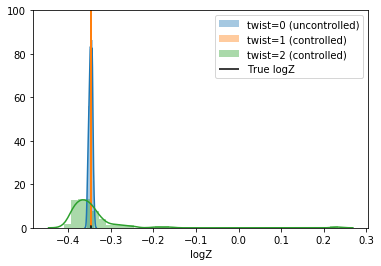

In [51]:
sns.distplot(logZs, label='twist=0 (uncontrolled)')
sns.distplot(twist1_logZs, label='twist=1 (controlled)')
sns.distplot(twist2_logZs, label='twist=2 (controlled)')
plt.xlabel(f"logZ")
plt.vlines(dG,0,1000, label=f"True logZ")
plt.ylim(0,100)
plt.legend()

so there might be a problem :/